In [1]:
import os
from PIL import Image
import numpy as np
import random
import shutil

In [2]:
# define directories for train and validation sets
root_dir = '/projectnb/ds340/projects/Samuolis_Parikh_Image_Data/'

train_dir = root_dir +"resized_images/train"
validation_dir = root_dir + "resized_images/validation"

train_target = train_dir +"/baldeagle"
train_nontarget = train_dir +"/nonbaldeagle"

val_target = validation_dir +"/baldeagle"
val_nontarget = validation_dir +"/nonbaldeagle"

In [3]:
def load_images_from_folders(folder1, folder2, img_size = (224,224)):
    images = []
    labels = []
    
    # Load images from the first folder
    for filename in os.listdir(folder1):
        img_path = os.path.join(folder1, filename)
        try:
            with Image.open(img_path) as img:
                img = img.convert('RGB')
                img = img.resize(img_size)
                images.append(np.array(img))  # Convert image to array
                labels.append(1)  # Class label for folder1
        except Exception as e:
            print(f"Could not load image {filename} from {folder1}: {e}")

    # Load images from the second folder
    for filename in os.listdir(folder2):
        img_path = os.path.join(folder2, filename)
        try:
            with Image.open(img_path) as img:
                img = img.convert('RGB')
                img = img.resize(img_size)
                images.append(np.array(img))
                labels.append(0)  # Class label for folder2
        except Exception as e:
            print(f"Could not load image {filename} from {folder2}: {e}")

    # convert lists to NumPy arrays
    
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

images_train, label_train = load_images_from_folders(train_target, train_nontarget)
images_val, label_val = load_images_from_folders(val_target, val_nontarget)

In [4]:
## for debugging:
print(images_train.shape, label_train.shape, type(images_train))
print(images_train.min(), images_train.max())  # expected: 0 255, later will normalize
print(f"Initial eagle count: {np.sum(label_train == 1)}")
print(f"Initial noneagle count: {np.sum(label_train == 0)}")

(5200, 224, 224, 3) (5200,) <class 'numpy.ndarray'>
0 255
Initial eagle count: 1300
Initial noneagle count: 3900


In [5]:
def change_labels(labels, percentage):
    random.seed(340)
    label_one_indices = np.where(labels == 1)[0]
    
    n = int(len(label_one_indices) * (percentage / 100))
    
    indices_to_change = np.random.choice(label_one_indices, size=n, replace=False)
    
    labels[indices_to_change] = 0
    
    return labels, indices_to_change

# for example, change 20% of label 1s to label 0
percentage = 0  
# changed_indices
# label_train, changed_indices = change_labels(label_train, percentage)

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.keras.utils.set_random_seed(340)
tf.config.experimental.enable_op_determinism()

2024-11-30 13:32:54.903235: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-30 13:32:54.937978: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732991574.952781  252179 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732991574.957234  252179 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 13:32:54.973116: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [7]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]
epochs = 15
# restore best weights make the model be the one that was the best instead of last one
# patience changed from 4-->3

In [8]:
# reload images
images_train, label_train = load_images_from_folders(train_target, train_nontarget)
percentage = 20  
# changed_indices
label_train, changed_indices = change_labels(label_train, percentage)

In [9]:
print(f"New eagle count: {np.sum(label_train == 1)}")
print(f"New noneagle count: {np.sum(label_train == 0)}")

New eagle count: 1040
New noneagle count: 4160


In [10]:
#Remake Models
#mutliple inputs taken from chat and https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
# we have full confidence if it is a 1, the lower the number the more confident you are in the 0 class
# .999999 vs .00004

from tensorflow.keras.layers import Input, Dropout, Concatenate
confidence_init = np.array([.35 if x<.5 else 1 for x in label_train]).reshape(5200,1)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True


# add new fully connected layers for binary classification
image_input = base_model.input
x = base_model.output
x = Flatten()(x)

additional_input = Input(shape=(1,), name="additional_input") #shape is just 1 feature for the confidence 
y = Dense(64, activation='relu')(additional_input) 
y = Dropout(0.1)(y) # when .5, the additional input was too powerful, the prediction vals were always either to close to 1 or 0, we try to make the additional input less important than the images

combined = Concatenate()([x, y]) # 2 channels
combined = Dense(256, activation='relu')(combined)
combined = Dense(1, activation='sigmoid')(combined)  # sigmoid for binary 

model = Model(inputs=[image_input, additional_input], outputs=combined)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], jit_compile=False)

I0000 00:00:1732991586.774817  252179 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14784 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:86:00.0, compute capability: 7.0


didnt run anything between this

In [11]:
history = model.fit(
    [images_train, confidence_init],
    label_train,
    batch_size = 32,
    epochs=epochs,  # adjust this for more epochs as needed
    validation_data=([images_val, label_val.reshape(-1,1)], label_val),
    callbacks = callbacks
)

Epoch 1/15


2024-11-30 13:33:09.124974: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
/projectnb/ds340/students/samuolis/.conda/envs/my_conda_env/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'additional_input']. Received: the structure of inputs=('*', '*')
  warning

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7770 - loss: 52.2530

2024-11-30 13:33:36.381616: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 145ms/step - accuracy: 0.7776 - loss: 52.0224 - val_accuracy: 1.0000 - val_loss: 0.0327
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - accuracy: 0.9994 - loss: 0.0441 - val_accuracy: 1.0000 - val_loss: 0.0049
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - accuracy: 1.0000 - loss: 0.0088 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 1.0000 - val_loss: 6.1727e-04
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 3.7679e-04
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 3.4066e-04
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - accuracy: 1.0000 - loss: 8.1428e-04 - val_accuracy: 1.0000 - val_loss: 9.3008e-05
Epoch 8/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - accuracy: 1.0000

In [ ]:
#accracy isnt what we care about rn, we care more about the confidence score and actual classigications
preds = model.predict([images_train, confidence_init])

In [ ]:
changed_indices.sort()
changed_indices

In [ ]:
np.where(label_train > .5)[0].shape #260 eagles missing, instead more eagles are getting flipped to noneagles

In [ ]:
preds
preds.reshape(5200,)
np.where(preds.reshape(5200,) >.5)[0].shape #find indices of those 17 indexes that were incorrectly flipped and flip them to correct label

In [ ]:
preds[changed_indices].mean() #preds for eagles labeled as 0, could we try flipping back top/highest value n percent of these back into eagles?

In [ ]:
preds[1300:].mean() #noneagles labeled as noneagles

In [ ]:
from scipy.stats import ttest_ind

tstat, pval = ttest_ind(preds[changed_indices], preds[1300:])

In [ ]:
pval

In [ ]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

and this

Instead of flipping the labels for the high non-eagle predictions, we can also/instead increase the confidence of the actual non eagles --> the confidences that are super low we can change the confidence_init to be 0 instead of 35 for those cases. 

In [ ]:
import numpy as np

# Define function to update labels based on misclassifications and confidence
def update_labels(preds, labels, changed_indices, confidence_init, threshold=0.05):
    new_labels = labels.copy()

    # Misclassified eagles: predicted as non-eagles (preds <= 0.5) but they are actually eagles (labels == 1)
    #this doesn't work... irl we don't know how many eagles there are... all we can do is change the ones we knew were eagles already
    misclassified_eagles = np.where((labels[:1300] == 1) & (preds[:1300] <= 0.5))[0]

    # Adjust confidence for misclassifications within the eagle class
    for idx in misclassified_eagles:
        confidence_init[idx] = min(confidence_init[idx] + 0.1, 1)  # Increase confidence for eagle class

    # Flip misclassified eagles to eagles (preds closer to 1) if confidently predicted
    for idx in misclassified_eagles:
        new_labels[idx] = 1  # Flip to eagle

    return new_labels  

# Iterative relabeling process
converged = False
iteration = 0
threshold = 0.05  # Statistical significance level
tolerance = 0.01  # Convergence tolerance (less than 1% labels change)

# Load initial data and change labels
images_train, label_train = load_images_from_folders(train_target, train_nontarget)
percentage = 20  
# Initialize changed_indices using the change_labels function
label_train, changed_indices = change_labels(label_train, percentage)   #can't actually use changed_indices anywhere-> thats just for 
#debugging and checking externally to see if its working...

# Start iterative process
while not converged:
    iteration += 1
    print(f"Iteration {iteration}...")

    # Retrain the model with the current labels and confidence scores
    history = model.fit(
        [images_train, confidence_init],  # Use updated confidence
        label_train,
        batch_size=32,
        epochs=1,  # To see values after each iteration
        validation_data=([images_val, label_val.reshape(-1, 1)], label_val),
        callbacks=callbacks,
        verbose=0
    )

    # Predict updated confidence scores from the model
    preds = model.predict([images_train, confidence_init]).flatten()

    # Filter `changed_indices` to keep only ambiguous predictions
    changed_indices = changed_indices[np.where((preds[changed_indices] > 0.3) & (preds[changed_indices] < 0.7))[0]]
    changed_indices = np.sort(changed_indices)

    print(f"Changed Indices: {changed_indices}")
    print(f"Predictions for Changed Indices: {preds[changed_indices]}")

    # Update labels based on misclassifications and confidence
    new_labels = update_labels(preds, label_train, changed_indices, confidence_init, threshold)

    # Update confidence scores to reflect updated predictions
    confidence_init = preds.reshape(-1, 1)

    # Check for convergence
    label_changes = np.sum(label_train != new_labels)
    change_ratio = label_changes / len(label_train)
    print(f"Label change ratio: {change_ratio:.4f}")
    print(f"Eagles in predictions: {np.sum(preds > 0.5)}")
    print(f"Noneagles in predictions: {np.sum(preds <= 0.5)}")

    # Check if the labels have converged by comparing the old and new labels
    if change_ratio < tolerance:  
        converged = True
    else:
        label_train = new_labels.copy()  # Update labels for the next iteration

print("Labels have converged.")

# Final print
eagle_count = np.sum(label_train == 1)
noneagle_count = np.sum(label_train == 0)
print(f"After Convergence - Correctly labeled eagles: {eagle_count}")
print(f"After Convergence - Correctly labeled noneagles: {noneagle_count}")


just to test distributions / debug

In [34]:
# Compare relabeled classes to original ground truth
original_labels = new_labels  
correct_eagles = np.sum((label_train == 1) & (original_labels == 1))  # True eagles as eagles
correct_noneagles = np.sum((label_train == 0) & (original_labels == 0))  # True noneagles as noneagles

print(f"Correctly labeled eagles: {correct_eagles}/{np.sum(original_labels == 1)}")
print(f"Correctly labeled noneagles: {correct_noneagles}/{np.sum(original_labels == 0)}")


Correctly labeled eagles: 1040/1040
Correctly labeled noneagles: 4160/4160


In [70]:
eagle_confidence = preds[label_train == 1]
noneagle_confidence = preds[label_train == 0]

print(f"Mean confidence for eagles: {eagle_confidence.mean():.4f}")
print(f"Mean confidence for noneagles: {noneagle_confidence.mean():.4f}")


Mean confidence for eagles: 0.0297
Mean confidence for noneagles: 0.0079


In [34]:
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(eagle_confidence, noneagle_confidence, equal_var=False)
print(f"T-statistic: {t_stat:.4f}, P-value: {p_val:.4e}")


T-statistic: 285.7584, P-value: 0.0000e+00


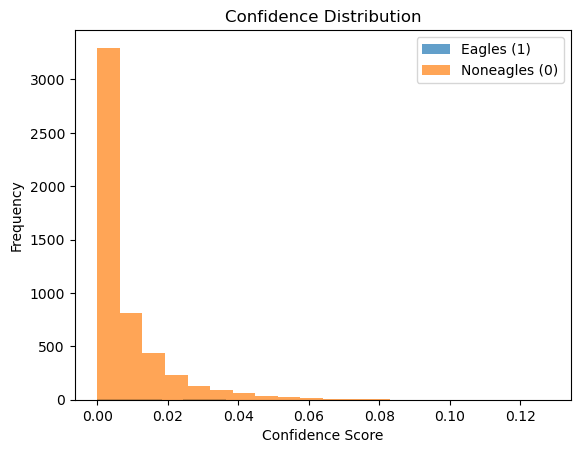

In [71]:
import matplotlib.pyplot as plt

plt.hist(eagle_confidence, bins=20, alpha=0.7, label='Eagles (1)')
plt.hist(noneagle_confidence, bins=20, alpha=0.7, label='Noneagles (0)')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Confidence Distribution')
plt.legend()
plt.show()


In [36]:
# Get indices of ambiguous samples
ambiguous_indices = np.where((preds > 0.4) & (preds < 0.6))[0]

# Inspect some ambiguous samples (requires image visualization logic)
for idx in ambiguous_indices[:10]:  # First 10 ambiguous cases
    print(f"Sample {idx}: Label={label_train[idx]}, Confidence={preds[idx]:.4f}")
    # Add your image visualization code here if needed


Sample 0: Label=0, Confidence=0.4747
Sample 1: Label=1, Confidence=0.5125
Sample 2: Label=1, Confidence=0.5125
Sample 3: Label=1, Confidence=0.5125
Sample 4: Label=1, Confidence=0.5125
Sample 5: Label=1, Confidence=0.5125
Sample 6: Label=1, Confidence=0.5125
Sample 7: Label=0, Confidence=0.4747
Sample 8: Label=1, Confidence=0.5125
Sample 9: Label=1, Confidence=0.5125
